In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from utils import plot_matrix

#### Load data from previous ipynb (preprocessing_dataset_ponds)

In [3]:
df = pd.read_pickle('data/postprocdata3x3_2k.csv')

In [4]:
X = pd.DataFrame(df['matrix'].tolist()).values
X = X.astype(np.float32)
y = df['target'].values
y = y.astype(np.int32)

# X_scaler = MinMaxScaler()
# X = X_scaler.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
X_train, y_train

(1500, 27) (500, 27)
(1500,) (500,)


(array([[203., 201., 244., ..., 200., 201., 247.],
        [ 99.,  57.,  55., ..., 129.,  76.,  84.],
        [217., 185., 154., ..., 209., 173., 133.],
        ...,
        [159., 127., 101., ..., 176., 149., 145.],
        [195., 152., 162., ..., 178., 140., 148.],
        [165., 131.,  81., ..., 176., 137., 110.]], dtype=float32),
 array([3, 1, 2, ..., 2, 3, 2], dtype=int32))

#### Calculate baseline with DummyClassifier

DummyClassifier is a classifier that makes predictions using simple rules (most frequent in this case). This classifier is useful as a simple baseline to compare with other (real) classifiers (http://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)

mean accuracy: 0.406


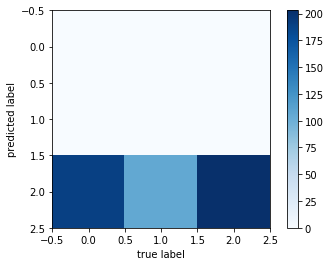

In [19]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent',random_state=0)
dummy.fit(X_train, y_train)
print("mean accuracy: {}".format(dummy.score(X_test, y_test)))
plot_matrix(dummy, X_test, y_test)

#### Test for Extremely Randomized Trees
It essentially consists of randomizing -partial or totally - both attribute and cut-point choice while splitting a tree node. In the extreme case, it builds totally randomized trees whose structures are independent of the output values of the learning sample. The strength of the randomization can be tuned to problem specifics by the appropriate choice of a parameter.

1 loop, best of 3: 443 ms per loop
             precision    recall  f1-score   support

          1       0.89      0.89      0.89       189
          2       0.71      0.89      0.79        85
          3       0.97      0.87      0.91       226

avg / total       0.89      0.88      0.88       500

Score over Testing Data 0.882
Score over Training Data 0.9626666666666667


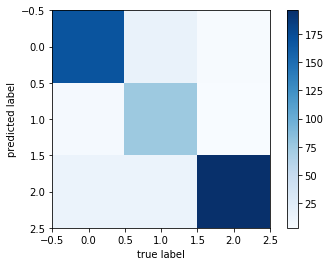

In [7]:
clf = ExtraTreesClassifier(n_estimators=200,
                           max_features=0.5, 
                           n_jobs=2,
                           max_depth=10,
                           # min_samples_split=1,
                           random_state=1)
%timeit clf.fit(X_train, y_train)
print(classification_report(clf.predict(X_test), y_test))
print("Score over Testing Data {}".format(clf.score(X_test, y_test)))
print("Score over Training Data {}".format(clf.score(X_train, y_train)))
plot_matrix(clf, X_test, y_test)

#### Gridsearch for best parameters

In [77]:
from sklearn.grid_search import GridSearchCV

parameter_grid = {
    'n_estimators': [100, 200],
    'max_features': [0.2, 0.5],
    'max_depth': [2, 5, 10]
}

grid_search = GridSearchCV(ExtraTreesClassifier(n_jobs=4), parameter_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=2, max_features=0.2, n_estimators=100 .................
[CV]  max_depth=2, max_features=0.2, n_estimators=100, score=0.695035 -   0.3s
[CV] max_depth=2, max_features=0.2, n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=2, max_features=0.2, n_estimators=100, score=0.732143 -   0.3s
[CV] max_depth=2, max_features=0.2, n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=2, max_features=0.2, n_estimators=100, score=0.728571 -   0.3s
[CV] max_depth=2, max_features=0.2, n_estimators=100 .................
[CV]  max_depth=2, max_features=0.2, n_estimators=100, score=0.727599 -   0.3s
[CV] max_depth=2, max_features=0.2, n_estimators=100 .................
[CV]  max_depth=2, max_features=0.2, n_estimators=100, score=0.738351 -   0.3s
[CV] max_depth=2, max_features=0.2, n_estimators=200 .................
[CV]  max_depth=2, max_features=0.2, n_estimators=200, score=0.702128 -   0.5s
[CV] max_depth=2, max_features=0.2, n_estimators=200 .................
[CV]  max_depth=2, max_features=0.2, n_estimators=200, score=0.714286 -   0.5s
[CV] max_depth=2, max_features=0.2, n_estimators=200 .................
[CV]  max_depth=2, max_features=0.2, n_estimators=200, score=0.721429 -   0.4s
[CV] max_depth=2, max_features=0.2, n_estimators=200 .................
[CV]  max_depth=2, max_features=0.2, n_estimators=200, score=0.727599 -   0.4s
[CV] max_depth=2, max

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   22.8s finished


{'max_depth': 10, 'max_features': 0.5, 'n_estimators': 200}

#### Crossvalidation over 10 iterations with a test size of 25% of the sample

In [20]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit

cv = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.25, random_state=0)

for name, classifier in zip(['ERT', 'SVM-rbf', 'Dummy'], [clf, sv, dummy]):
    test_scores = cross_val_score(classifier, X, y, cv=cv, n_jobs=4)
    print('*'*4, name, '*'*4)
    print("scores: {}\n mean: {}\n std: {}".format(str(test_scores),
                                             np.mean(test_scores), np.std(test_scores)))

**** ERT ****
scores: [0.866 0.856 0.856 0.864 0.842 0.87  0.854 0.882 0.84  0.868]
 mean: 0.8598000000000001
 std: 0.01221310771261763
**** SVM-rbf ****
scores: [0.406 0.41  0.41  0.366 0.428 0.4   0.4   0.372 0.386 0.444]
 mean: 0.4022
 std: 0.02245796072665548
**** Dummy ****
scores: [0.396 0.398 0.4   0.356 0.418 0.394 0.38  0.366 0.37  0.428]
 mean: 0.3906
 std: 0.02161573500947863


1 loop, best of 3: 925 ms per loop
             precision    recall  f1-score   support

          1       0.02      1.00      0.04         4
          2       0.00      0.00      0.00         0
          3       1.00      0.41      0.58       496

avg / total       0.99      0.41      0.58       500

Score over Testing Data 0.414
Score over Training Data 1.0


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


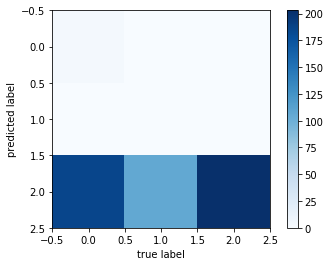

In [15]:
from sklearn.svm import SVC

sv = SVC(kernel='rbf', cache_size=6000, probability=True)
%timeit sv.fit(X_train, y_train)
print(classification_report(sv.predict(X_test), y_test))
print("Score over Testing Data {}".format(sv.score(X_test, y_test)))
print("Score over Training Data {}".format(sv.score(X_train, y_train)))
plot_matrix(sv, X_test, y_test)